In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle

In [2]:
# load data
with open('tof_data_run.pkl', 'rb') as f:
    tof_data_list = pickle.load(f)
with open('tof_time_run.pkl', 'rb') as f:
    tof_time_list = pickle.load(f)
with open('pwm_data_run.pkl', 'rb') as f:
    pwm_data_list = pickle.load(f)

In [3]:
# values from step response
d = 0.000568
rise_time_90 = 0.781

# compute m and d_m
m   = (-d*rise_time_90) / math.log(0.1)
print("   m =  {m:.6f}".format(m=m))
d_m = (-d / m)
print("-d/m = {dm:.6f}".format(dm=d_m))

   m =  0.000193
-d/m = -2.948252


In [4]:
# init A, B, C matrices
A = np.array([[0,1],
              [0, d_m]])
B = np.array([[0],[1/m]])
C = np.array([[-1,0]])

In [5]:
# estimate noise
delta_t = 0.065      # 105ms calculated from long range mode sample, 65ms for short range mode
sig_measure = 40     # assume sigma = 40 when moving
sig_proc    = math.sqrt(100 * (1/delta_t))  
print(sig_proc)

39.2232270276368


In [6]:
# build noise matrices
sig_u = np.array([[sig_measure**2,0],
                  [0,sig_measure**2]])
sig_z = np.array([[sig_proc**2]])

In [7]:
# Discretize A and B
Ad = np.eye(2) + delta_t * A
Bd = delta_t * B

In [8]:
# filter definition
def kf(mu, u, sigma, y):
    mu_p     = Ad.dot(mu) + Bd.dot(u)
    sigma_p  = Ad.dot(sigma.dot(Ad.transpose())) + sig_u
    
    sigma_m  = C.dot(sigma_p.dot(C.transpose())) + sig_z
    kkf_gain = sigma_p.dot(C.transpose().dot(np.linalg.inv(sigma_m)))
    
    y_m      = y - C.dot(mu_p)
    mu       = mu_p + kkf_gain.dot(y_m)
    sigma    = (np.eye(2) - kkf_gain.dot(C)).dot(sigma_p)
    
    return mu, sigma

In [9]:
# initial conditions
sig = np.array([[10**2,0],[0,10**2]])
x = np.array([[-tof_data_list[0]],[0]])

# run KF
kf_state = []
for u, d in zip(pwm_data_list, tof_data_list):
    x, sig = kf(x, [[u/100]], sig, [[d]])
    kf_state.append(x[:,0])

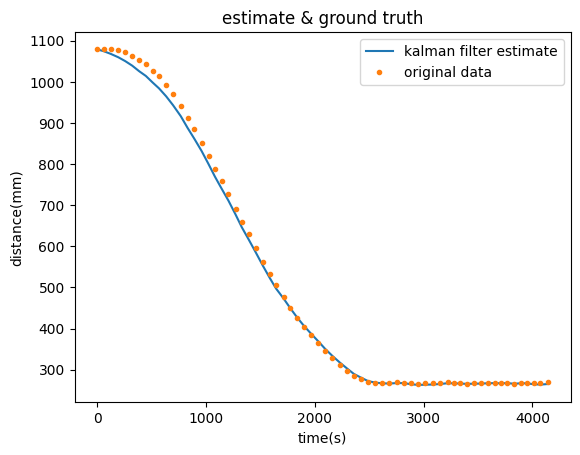

In [10]:
plt.plot(tof_time_list, [-x[0] for x in kf_state], label="kalman filter estimate")
plt.plot(tof_time_list, [x for x in tof_data_list], '.', label ="original data" )
plt.xlabel('time(s)')
plt.ylabel('distance(mm)')
plt.legend(loc="upper right")
plt.title('estimate & ground truth')
plt.show()